Epoch [0/10] Batch [0/938] Loss D: 1.388853907585144, Loss G: 0.7090550661087036


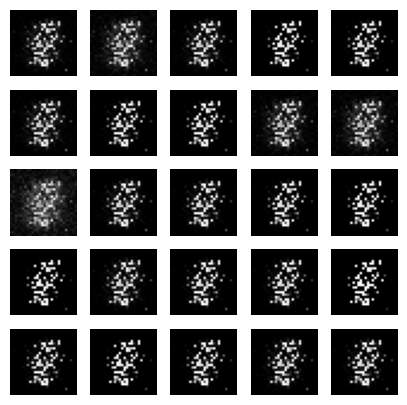

Epoch [1/10] Batch [0/938] Loss D: 0.5087303519248962, Loss G: 6.8597307205200195


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Generator(nn.Module):

    def __init__(self, input_dim, output_dim):

        super(Generator, self).__init__()

        self.main = nn.Sequential(

            nn.Linear(100, 256),

            nn.ReLU(True),

            nn.Linear(256, 512),

            nn.ReLU(True),

            nn.Linear(512, 1024),

            nn.ReLU(True),

            nn.Linear(1024, 784),

            nn.Tanh()

        )



    def forward(self, input):

        return self.main(input)



# Define the discriminator network

class Discriminator(nn.Module):

    def __init__(self, input_dim):

        super(Discriminator, self).__init__()

        self.main = nn.Sequential(

            nn.Linear(784, 1024),

            nn.LeakyReLU(0.2, inplace=True),

            nn.Dropout(0.3),

            nn.Linear(1024, 512),

            nn.LeakyReLU(0.2, inplace=True),

            nn.Dropout(0.3),

            nn.Linear(512, 256),

            nn.LeakyReLU(0.2, inplace=True),

            nn.Dropout(0.3),

            nn.Linear(256, 1),

            nn.Sigmoid()

        )



    def forward(self, input):

        return self.main(input)


latent_dim = 100
image_dim = 28 * 28

generator = Generator(latent_dim, image_dim).to(device)
discriminator = Discriminator(image_dim).to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True)

criterion = nn.BCELoss()

lr = 0.0002

optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

num_epochs = 10
sample_interval = 2000

def save_generated_images(epoch, generator, num_images=25, figsize=(5, 5)):

    z = torch.randn(num_images, latent_dim)
    generated_images = generator(z)
    generated_images = generated_images.view(generated_images.size(0), 1, 28, 28)
    generated_images = generated_images.data.cpu().numpy()
    fig, axes = plt.subplots(5, 5, figsize=figsize)
    count = 0
    for i in range(5):
        for j in range(5):
            axes[i, j].imshow(generated_images[count, 0], cmap='gray')
            axes[i, j].axis('off')
            count += 1
    plt.show()



for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(data_loader):
        real_imgs = imgs.view(imgs.size(0), -1).to(device)
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)

        d_real = discriminator(real_imgs)
        d_fake = discriminator(fake_imgs)

        d_real_loss = criterion(d_real, real_labels)
        d_fake_loss = criterion(d_fake, fake_labels)
        d_loss = d_real_loss + d_fake_loss

        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()


        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        d_fake = discriminator(fake_imgs)
        g_loss = criterion(d_fake, real_labels)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if i % sample_interval == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(data_loader)}] "
                  f"Loss D: {d_loss.item()}, Loss G: {g_loss.item()}")

    save_generated_images(epoch, generator)